# Application: Classification des réclamations d'assurance-vie

## Introduction

Dans ce notebook, nous explorerons le concept de classification binaire en utilisant la régression logistique avec `R`. Nous utiliserons un scénario du secteur de l'assurance : prédire si un titulaire de police d'assurance-vie fera une réclamation dans une période donnée.

## 1. Configuration de notre environnement

- Nous utilisons `tidyverse` pour la manipulation des données et la visualisation.
- `caret` nous aidera pour la modélisation et l'évaluation.
- `pROC` sera utilisé pour tracer la courbe ROC.
- La définition d'une graine aléatoire garantit que nos processus aléatoires sont reproductibles.

In [2]:
library(tidyverse)
library(caret)
library(pROC)

# Définition du seed aléatoire pour la reproductibilité
set.seed(3035)

## 2. Génération de données synthétiques

Dans un scénario réel, vous chargeriez généralement des données à partir d'un fichier csv par exemple `read.csv` ou d'une base de données. Pour cet exemple, nous allons créer des données synthétiques pour imiter les informations réelles des titulaires de polices d'assurance.


In [3]:
n <- 1000
donnees <- tibble(
  age = runif(n, 20, 70),
  imc = rnorm(n, 25, 5),
  tension_arterielle = rnorm(n, 120, 15),
  cholesterol = rnorm(n, 200, 30),
  fumeur = sample(c("oui", "non"), n, replace = TRUE, prob = c(0.2, 0.8)),
  antecedents_familiaux = sample(c("oui", "non"), n, replace = TRUE),
  frequence_exercice = sample(c("faible", "moyenne", "elevee"), n, replace = TRUE)
)

Nous avons créé un jeu de données avec 1000 titulaires de polices, chacun avec diverses caractéristiques de santé et de style de vie.

La variable 'reclamation' est notre cible. Elle est binaire (0 ou 1) et représente si un titulaire de police a fait une réclamation.

In [4]:
donnees <- donnees %>%
  mutate(
    proba_reclamation = 0.01 +
      0.001 * (age - 20) +
      0.02 * (imc - 25) +
      0.002 * (tension_arterielle - 120) +
      0.001 * (cholesterol - 200) +
      0.1 * (fumeur == "oui") +
      0.05 * (antecedents_familiaux == "oui") +
      -0.05 * (frequence_exercice == "elevee"),
    reclamation = rbinom(n, 1, proba_reclamation)
  ) %>%
  select(-proba_reclamation)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `reclamation = rbinom(n, 1, proba_reclamation)`.
Caused by warning in `rbinom()`:
! NAs produced”


In [5]:
print(head(donnees))

# A tibble: 6 × 8
    age   imc tension_arterielle cholesterol fumeur antecedents_familiaux
  <dbl> <dbl>              <dbl>       <dbl> <chr>  <chr>                
1  30.5  25.6               97.5        161. oui    oui                  
2  66.0  27.3              136.         197. non    non                  
3  51.0  17.8               99.5        222. non    non                  
4  46.7  19.8              138.         213. non    oui                  
5  43.7  30.2              113.         191. oui    oui                  
6  37.8  19.9              143.         149. oui    oui                  
# ℹ 2 more variables: frequence_exercice <chr>, reclamation <int>


In [6]:
print(paste("Dimensions des données :", paste(dim(donnees), collapse = " x ")))

[1] "Dimensions des données : 1000 x 8"


Nous avons généré 'reclamation' en fonction d'une probabilité influencée par d'autres caractéristiques, en ajoutant un peu d'aléatoire pour imiter la complexité du monde réel.

## 3. Analyse exploratoire des données
Avant de construire notre modèle, il est crucial de comprendre nos données.

### Statistiques de base

In [7]:
summary(donnees)

      age             imc         tension_arterielle  cholesterol   
 Min.   :20.06   Min.   : 7.216   Min.   : 76.18     Min.   :101.0  
 1st Qu.:32.11   1st Qu.:21.839   1st Qu.:109.38     1st Qu.:180.1  
 Median :44.55   Median :25.047   Median :120.11     Median :201.0  
 Mean   :44.99   Mean   :24.996   Mean   :119.70     Mean   :200.6  
 3rd Qu.:58.25   3rd Qu.:28.078   3rd Qu.:129.56     3rd Qu.:221.0  
 Max.   :69.99   Max.   :43.790   Max.   :162.91     Max.   :285.5  
                                                                    
    fumeur          antecedents_familiaux frequence_exercice  reclamation   
 Length:1000        Length:1000           Length:1000        Min.   :0.000  
 Class :character   Class :character      Class :character   1st Qu.:0.000  
 Mode  :character   Mode  :character      Mode  :character   Median :0.000  
                                                             Mean   :0.113  
                                                             3r

### Carte de chaleur des corrélations

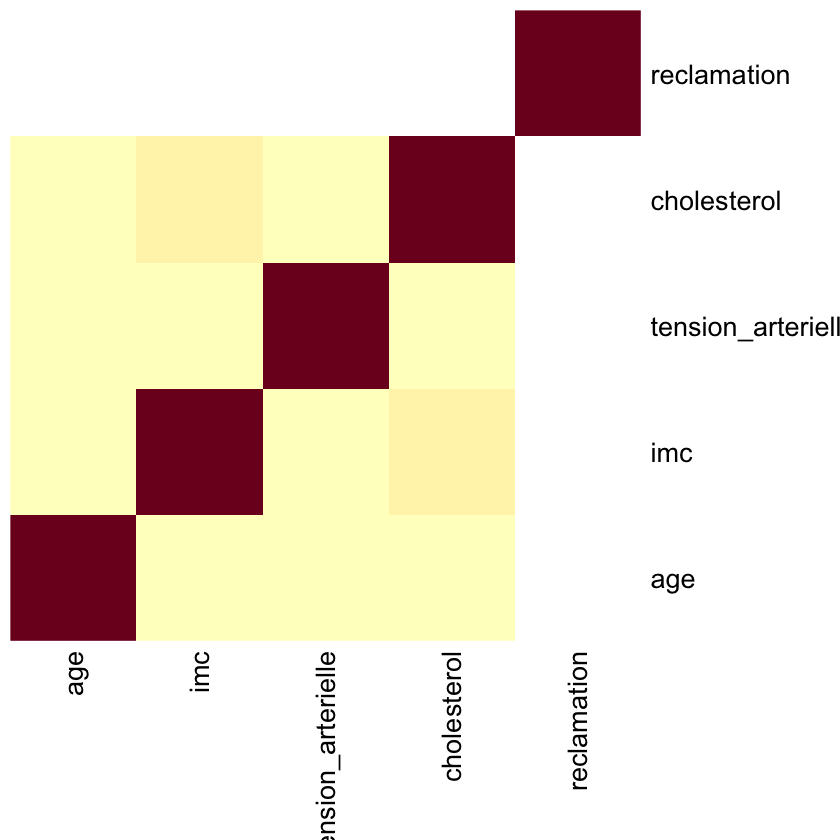

In [8]:
donnees %>%
  select(where(is.numeric)) %>%
  cor() %>%
  heatmap(Rowv = NA, Colv = NA, scale = "none", margins = c(10, 10))

### Distribution des réclamations

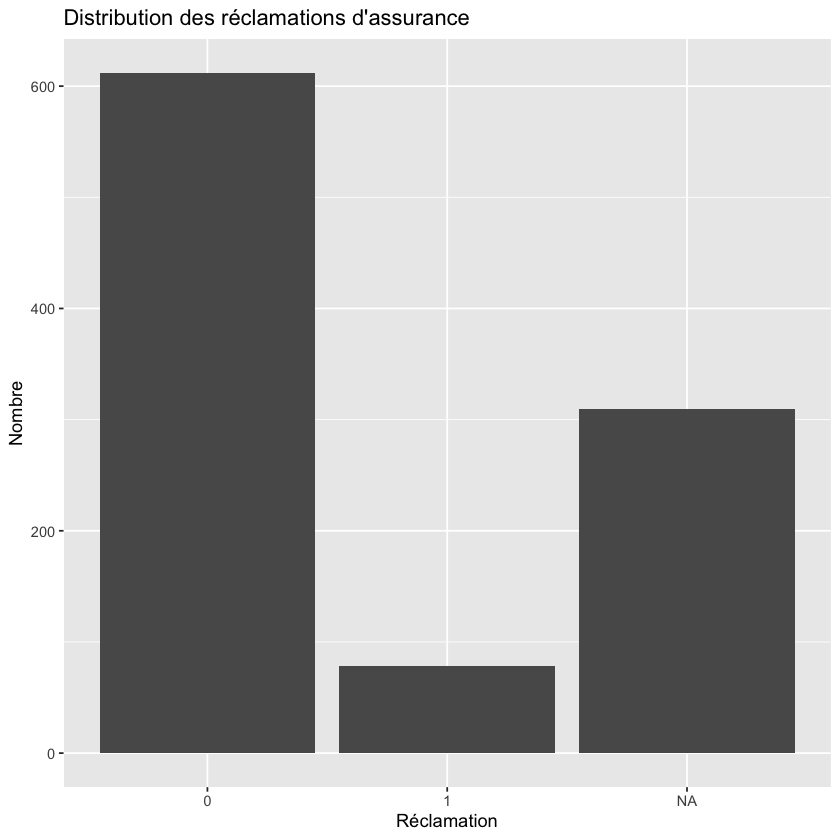

In [9]:
ggplot(donnees, aes(x = factor(reclamation))) +
  geom_bar() +
  labs(title = "Distribution des réclamations d'assurance", x = "Réclamation", y = "Nombre")

### Nuage de points âge vs IMC, coloré par statut de réclamation

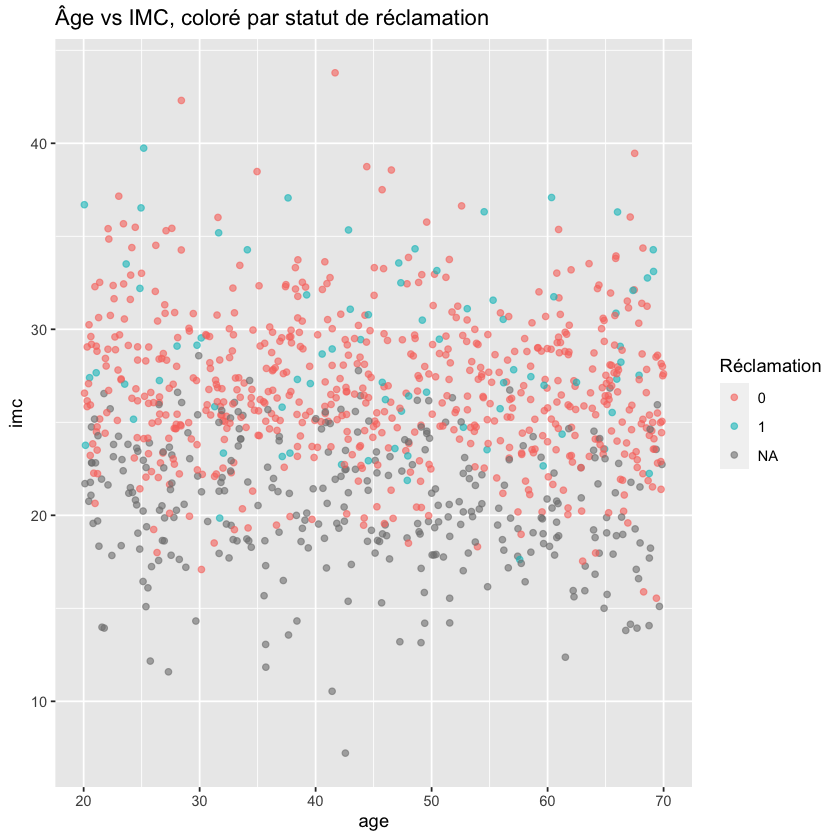

In [10]:
ggplot(donnees, aes(x = age, y = imc, color = factor(reclamation))) +
  geom_point(alpha = 0.6) +
  labs(title = "Âge vs IMC, coloré par statut de réclamation", color = "Réclamation")

- La fonction `summary()` nous donne un aperçu rapide de nos caractéristiques.
- La carte de type "heat map" des corrélations nous aide à visualiser les relations entre les caractéristiques numériques.
- Nous traçons la distribution des réclamations pour vérifier le déséquilibre des classes.
- Le nuage de points de l'âge par rapport à l'IMC, coloré par le statut de réclamation, peut révéler des tendances dans ces variables clés

## 4. Prétraitement des données

Maintenant, préparons nos données pour le modèle de régression logistique.

In [17]:
# Conversion des variables catégorielles en variables indicatrices
donnees_encodees <- donnees %>%
  mutate(across(where(is.character), as.factor))
# donnees <- donnees %>% filter(!is.na(reclamation))
# Séparation des caractéristiques et de la cible (variable réponse)
X <- donnees_encodees %>% select(-reclamation)
y <- donnees_encodees$reclamation

# Division en ensembles d'entraînement et de test
indices_partition <- sample(1:length(y), size = floor(0.8 * length(y)))
X_train <- X[indices_partition, ]
X_test <- X[-indices_partition, ]
y_train <- y[indices_partition]
y_test <- y[-indices_partition]

print(paste("Dimensions de l'ensemble d'entraînement :", paste(dim(X_train), collapse = " x ")))
print(paste("Dimensions de l'ensemble de test :", paste(dim(X_test), collapse = " x ")))

[1] "Dimensions de l'ensemble d'entraînement : 552 x 7"
[1] "Dimensions de l'ensemble de test : 138 x 7"


- Nous convertissons les variables catégorielles en facteurs.
- Nous séparons nos caractéristiques (X) de notre variable cible (y).
- Nous divisons nos données en ensembles d'entraînement (80%) et de test (20%). L'ensemble d'entraînement est utilisé pour construire le modèle, tandis que l'ensemble de test est utilisé pour évaluer sa performance.


## 5. Construction du modèle de régression logistique

Nous sommes maintenant prêts à créer et à entraîner notre modèle de régression logistique.


In [18]:
modele <- glm(reclamation ~ ., data = cbind(X_train, reclamation = y_train), family = binomial())

In [19]:
summary(modele)


Call:
glm(formula = reclamation ~ ., family = binomial(), data = cbind(X_train, 
    reclamation = y_train))

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -9.817430   2.023660  -4.851 1.23e-06 ***
age                        0.012652   0.009323   1.357   0.1748    
imc                        0.133906   0.031935   4.193 2.75e-05 ***
tension_arterielle         0.006940   0.009361   0.741   0.4585    
cholesterol                0.008668   0.004647   1.865   0.0621 .  
fumeuroui                  0.621996   0.295628   2.104   0.0354 *  
antecedents_familiauxoui   0.602033   0.282763   2.129   0.0332 *  
frequence_exercicefaible   0.509669   0.358021   1.424   0.1546    
frequence_exercicemoyenne  0.585009   0.348946   1.677   0.0936 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 412.05  on 551  degrees of freedom
Residual devian

## 6. Évaluation du modèle
Évaluons maintenant la performance de notre modèle.

Warning message in confusionMatrix.default(factor(y_pred_class), factor(y_test)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 128  10
         1   0   0
                                          
               Accuracy : 0.9275          
                 95% CI : (0.8708, 0.9647)
    No Information Rate : 0.9275          
    P-Value [Acc > NIR] : 0.583099        
                                          
                  Kappa : 0               
                                          
 Mcnemar's Test P-Value : 0.004427        
                                          
            Sensitivity : 1.0000          
            Specificity : 0.0000          
         Pos Pred Value : 0.9275          
         Neg Pred Value :    NaN          
             Prevalence : 0.9275          
         Detection Rate : 0.9275          
   Detection Prevalence : 1.0000          
      Balanced Accuracy : 0.5000          
                                          
       'Positive' Class : 0               
                              

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.6812

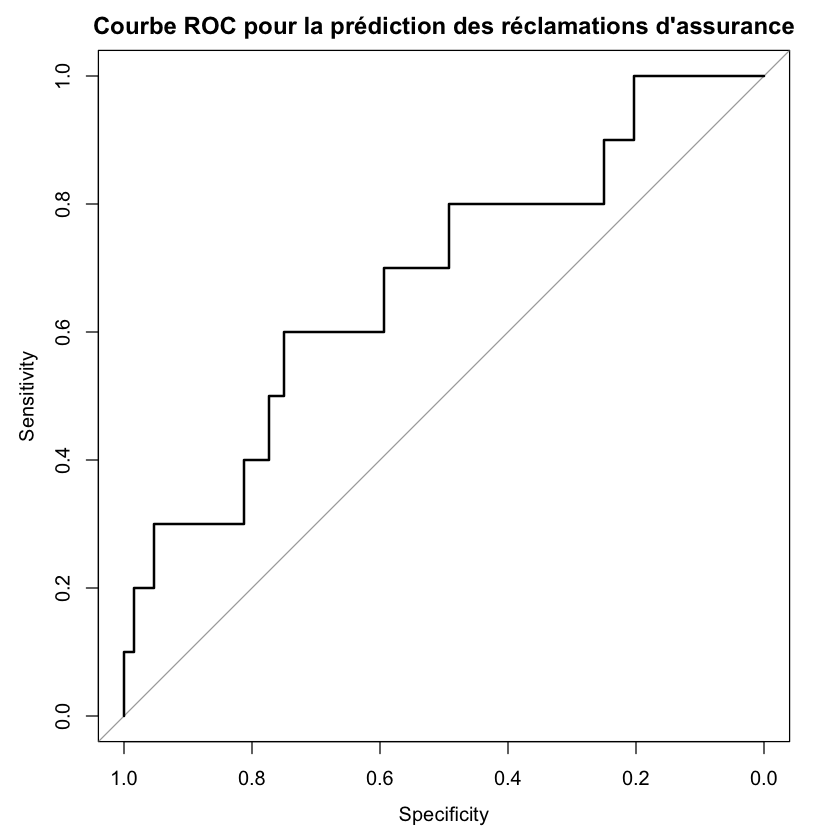

In [20]:
# Faire des prédictions sur l'ensemble de test
y_pred <- predict(modele, newdata = X_test, type = "response")
y_pred_class <- ifelse(y_pred > 0.5, 1, 0)

# Matrice de confusion
conf_matrix <- confusionMatrix(factor(y_pred_class), factor(y_test))
print(conf_matrix)

# Courbe ROC
courbe_roc <- roc(y_test, y_pred)
plot(courbe_roc, main = "Courbe ROC pour la prédiction des réclamations d'assurance")
auc(courbe_roc)

- La matrice de confusion nous montre les vrais positifs, vrais négatifs, faux positifs et faux négatifs du modèle.
- La courbe ROC (Receiver Operating Characteristic) trace le taux de vrais positifs par rapport au taux de faux positifs à différents seuils. L'aire sous la courbe (AUC) est une mesure du pouvoir prédictif du modèle.


## 7. Faire des prédictions

Enfin, utilisons notre modèle pour faire des prédictions pour de nouveaux titulaires de polices.

In [21]:
predire_probabilite_reclamation <- function(age, imc, tension_arterielle, cholesterol, fumeur, antecedents_familiaux, frequence_exercice) {
  nouvelles_donnees <- tibble(
    age = age,
    imc = imc,
    tension_arterielle = tension_arterielle,
    cholesterol = cholesterol,
    fumeur = factor(fumeur, levels = levels(X_train$fumeur)),
    antecedents_familiaux = factor(antecedents_familiaux, levels = levels(X_train$antecedents_familiaux)),
    frequence_exercice = factor(frequence_exercice, levels = levels(X_train$frequence_exercice))
  )
  
  predict(modele, newdata = nouvelles_donnees, type = "response")
}

In [22]:
proba <- predire_probabilite_reclamation(45, 28, 130, 220, "non", "oui", "moyenne")
print(paste("La probabilité que ce titulaire de police fasse une réclamation est de :", round(proba, 4)))

[1] "La probabilité que ce titulaire de police fasse une réclamation est de : 0.182"


- Nous avons créé une fonction qui prend les informations d'un nouveau titulaire de police et renvoie la probabilité qu'il fasse une réclamation.
- Cette fonction prétraite les données d'entrée de la même manière que nos données d'entraînement, assurant ainsi la cohérence.
- Le résultat est une probabilité entre 0 et 1, qui peut être utilisée pour prendre des décisions ou évaluer le risque.

## Conclusion

Dans ce notebook, nous avons parcouru l'ensemble du processus de construction d'un modèle de régression logistique pour prédire les réclamations d'assurance en utilisant R. Nous avons couvert la préparation des données, l'analyse exploratoire, la construction du modèle, l'évaluation et l'application pratique.
